In [1]:
import cv2
import numpy as np
import os
import random
import torch

from uuid import uuid4

from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt
from PIL import Image

from deeplab_vandaele import remove_non_river
from mask_rcnn_coco import remove_boats
from utils import get_device, load_image

In [2]:
imgs = [
    'images/images/868df0899e668.jpg',
    'images/images/1cfecac9fd128.jpg',
    'images/images/2d43805e5efd4.jpg',
    'images/images/3cde210a9022e.jpg',
    'images/images/1eb0743881e5f.jpg',
    'images/images/1cfecac9fd128.jpg'
]
for a, b, c in os.walk('images/images'):
    for filename in random.sample(c, 4):
        if('.jpg' in filename):
            print('%s/%s' % (a, filename))
            # import images as grayscale 1D of ints ranging 0 - 255 (intensity) 
            imgs.append('%s/%s' % (a, filename))
print(len(imgs))

images/images/e0ce6c5be6b08.jpg
images/images/b655af1f019e5.jpg
images/images/6d8e8733ad4f.jpg
images/images/72775d70048cd.jpg
10


In [3]:
device = get_device()

Device: NVIDIA GeForce RTX 3070 Laptop GPU


In [5]:
images = []
for img_path in imgs:
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, dsize=(640, 360), interpolation= cv2.INTER_LINEAR)
    img, raw_img = load_image(img_path, device)
    removed_river_image = remove_non_river(img, raw_img, device)
    removed_boat_image = remove_boats(removed_river_image, device)
    
    images.append({
        'filename': img_path, 
        "original": image, 
        'removed_river': removed_river_image, 
        'removed_boat': removed_boat_image
    })
    
len(images)

C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\chris\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=None`.
  warnings.warn(msg)


torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])
torch.Size([3, 360, 640])


10

NameError: name 'images' is not defined

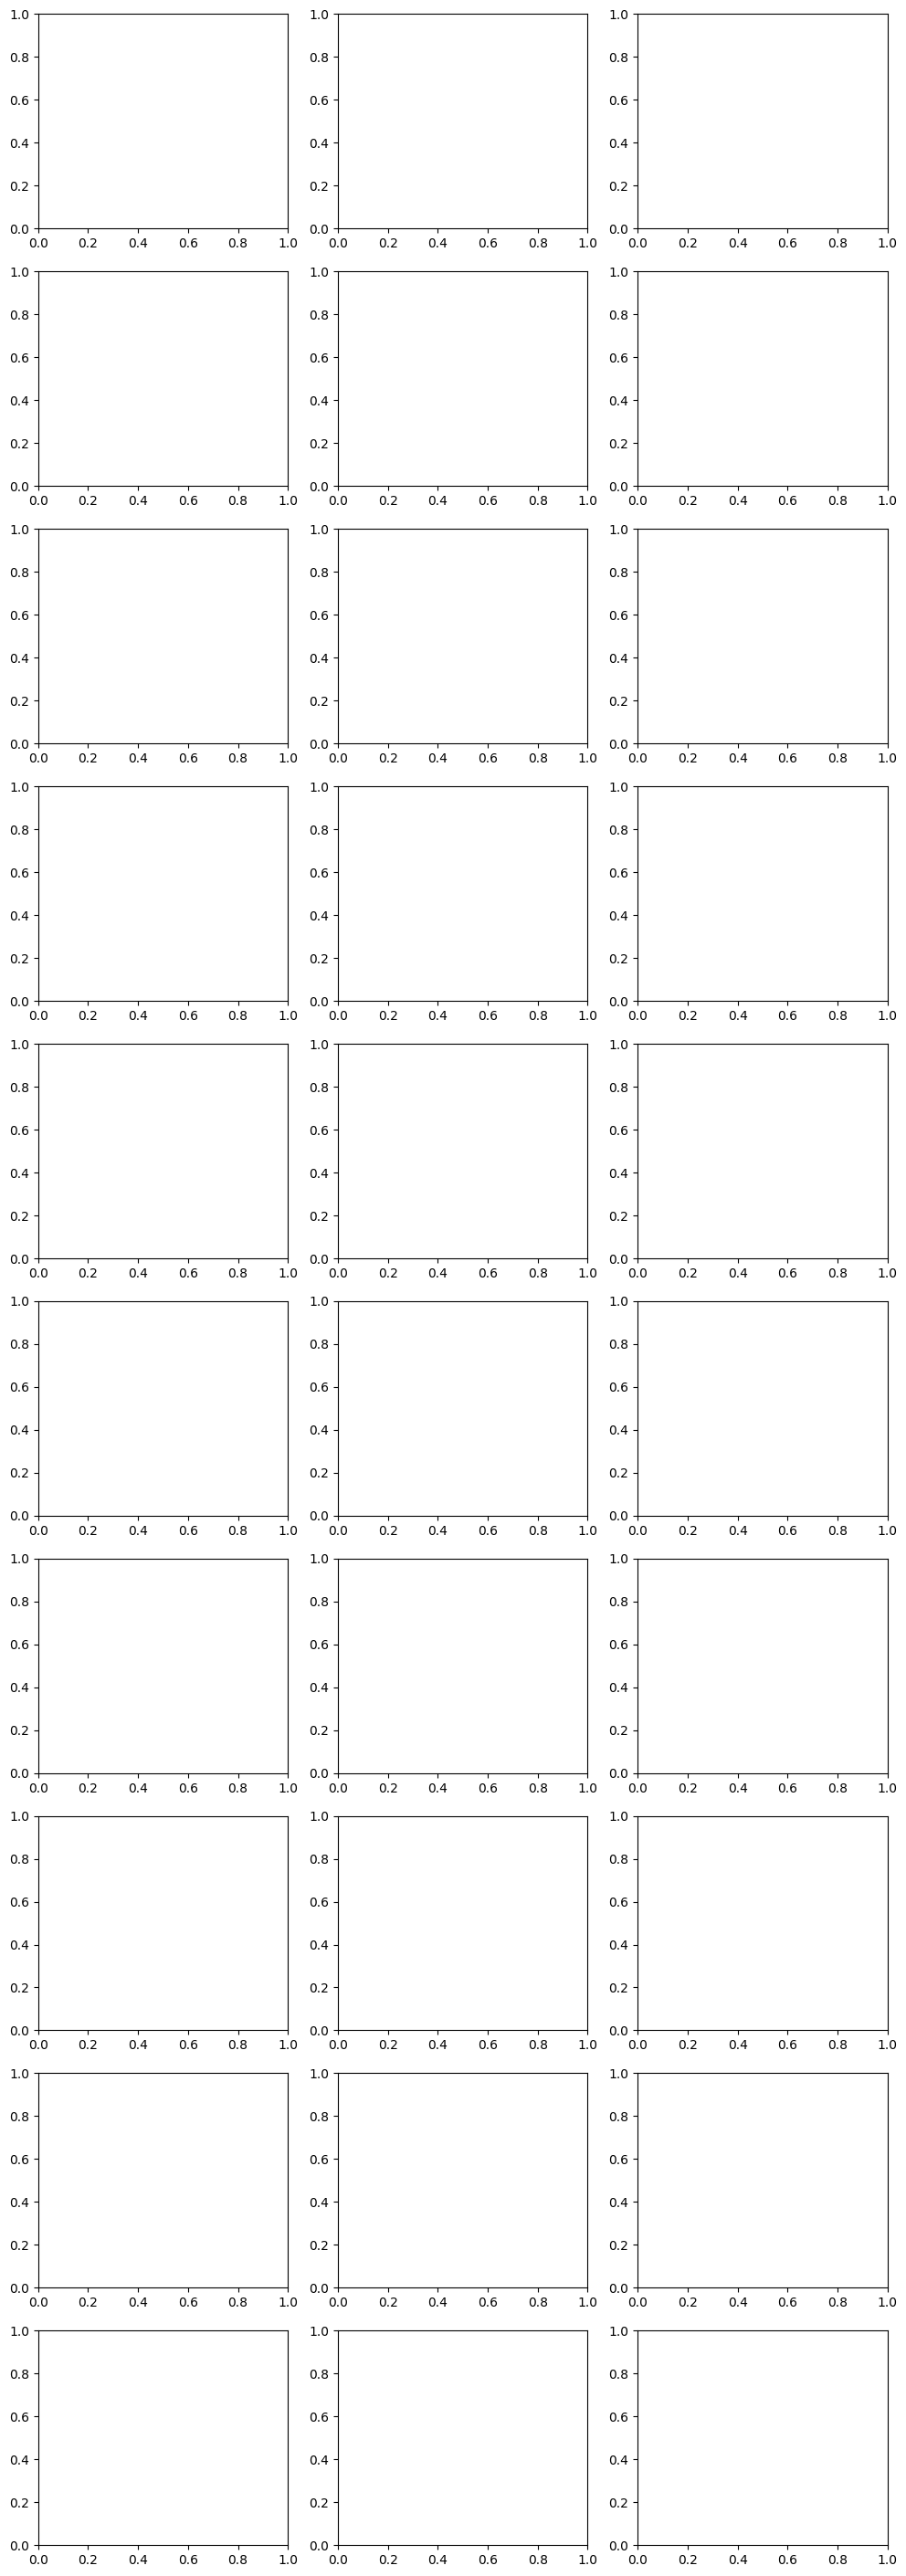

In [4]:
f, axarr = plt.subplots(len(imgs), 3, figsize=(12, 36))

for r in range(len(imgs)):
    axarr[r, 0].imshow(images[r]['original'])
#     axarr[row, 0].set_title(images[row]['filename'])
        
    axarr[r, 1].imshow(images[r]['removed_river'])
#     axarr[row, 1].set_title("river removed")
        
    axarr[r, 2].imshow(images[r]['removed_boat'])
#     axarr[row, 2].set_title("boat removed")

    axarr[r, 0].axis('off')
    axarr[r, 1].axis('off')
    axarr[r, 2].axis('off')

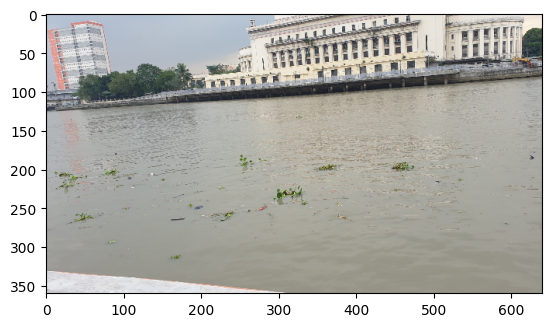

In [29]:
img, raw_img = load_image(imgs[1], device)
plt.imshow(raw_img)

torch.Size([3, 360, 640])


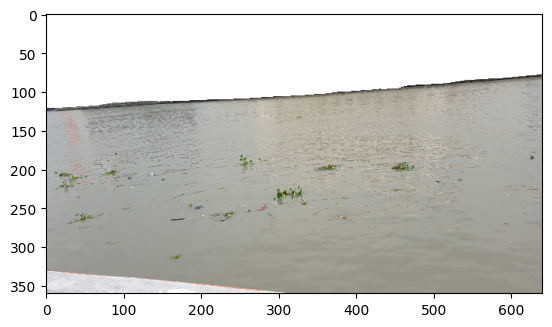

In [30]:
removed_river_image = remove_non_river(img, raw_img, device)
removed_boat_image = remove_boats(removed_river_image, device)

plt.imshow(removed_boat_image)

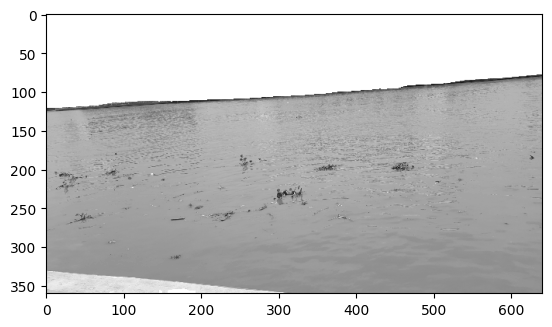

In [32]:
img_gray = cv2.cvtColor(removed_boat_image, cv2.COLOR_BGR2GRAY)
height, width = img_gray.shape

plt.imshow(img_gray, cmap ="gray")

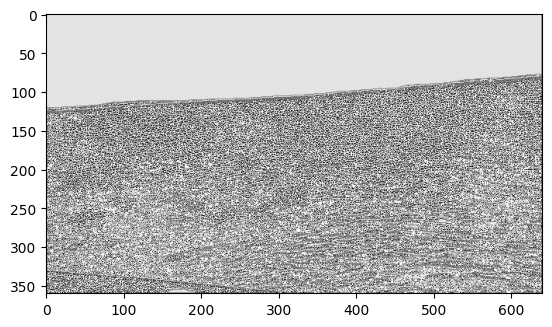

In [33]:
# type of LBP
METHOD = 'uniform'  # at most two circular 0-1 or 1-0 transitions
radius = 1  # distance between central pixels and comparison pixels
n_points = 8 * radius  # define number of comparison pixels

lbp_img = local_binary_pattern(img_gray, n_points, radius, METHOD)
plt.imshow(lbp_img, cmap='gray')

In [34]:
def hist(lbp):
    '''
    Create a histogram
    :param axis: matplotlib axes
    :param lbp: ndarray local binary pattern representation of an image
    :return: matplotliob histogram
    '''
    n_bins = int(lbp.max() + 1) # number of bins based on number of different values in lbp
    return plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5') # np.ravel() returns a flattened 1D array

(array([0.05126736, 0.06851128, 0.02145399, 0.04607205, 0.05530382,
        0.09085069, 0.0418099 , 0.08344184, 0.40392795, 0.13736111]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

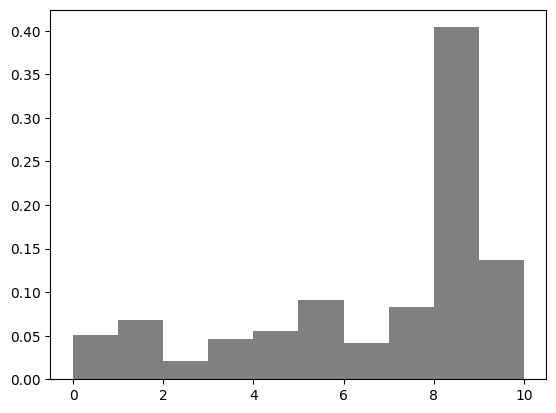

In [35]:
hist(lbp_img)

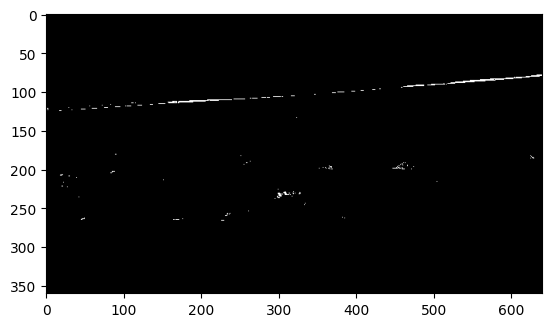

In [36]:
kernel = np.ones((5,5),np.uint8)

_, threshold = cv2.threshold(img_gray, 64, 255, cv2.THRESH_BINARY_INV)

plt.imshow(threshold, cmap='gray')

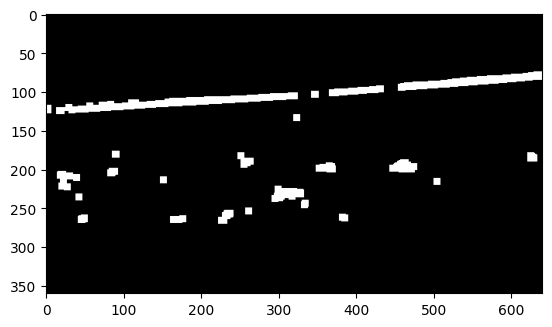

In [37]:
# Noise removal using Morphological open operation
kernel = np.ones((5,5),np.uint8)
morphOpen = cv2.dilate(threshold, kernel, iterations=2)
morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)

plt.imshow(morphOpen, cmap='gray')

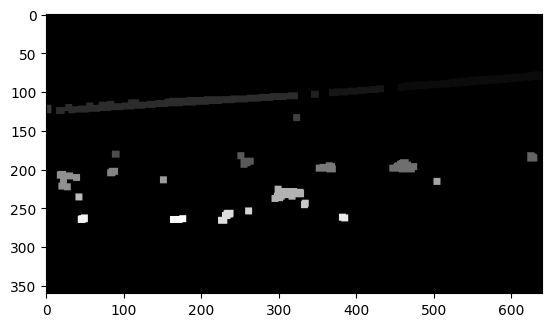

In [38]:
from skimage.measure import label, regionprops

label_im = label(morphOpen)
plt.imshow(label_im, cmap='gray')

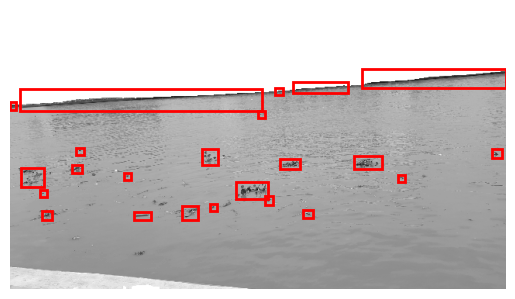

In [39]:
fig, ax = plt.subplots()
plt.imshow(img_gray, cmap='gray')

labels = regionprops(label_im)

for i in labels:
    minr, minc, maxr, maxc = i.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    
    ax.add_patch(rect)
ax.set_axis_off()
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [40]:
# metadata = {
#     'filename': [],
#     'type': [],
# }

NameError: name 'metadata' is not defined

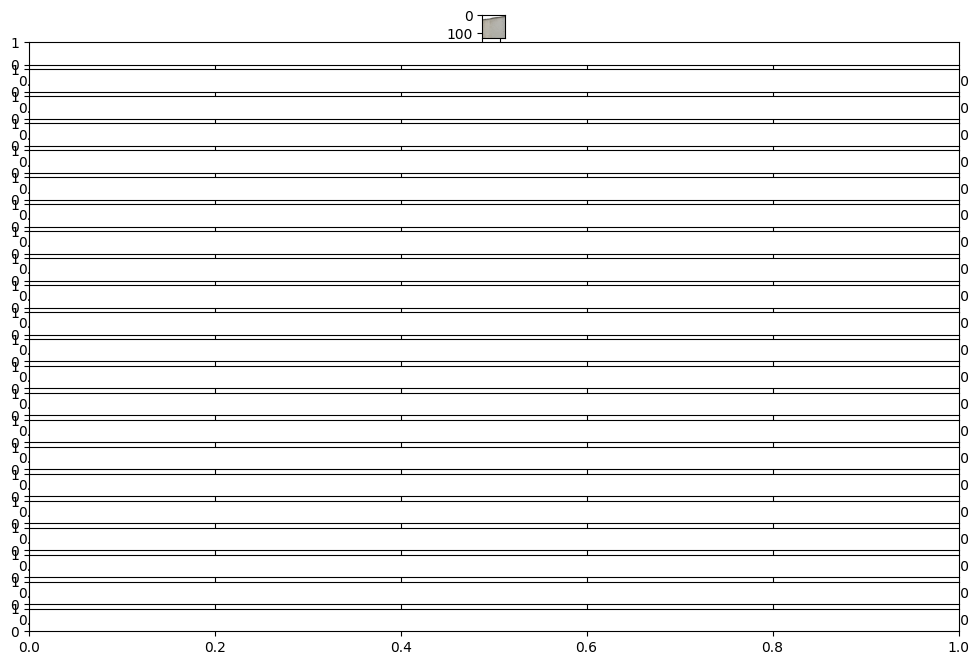

In [41]:
f, axarr = plt.subplots(len(labels), 1, figsize=(12, 8))

for i in range(len(labels)):
    minr, minc, maxr, maxc = labels[i].bbox
    area = (maxr - minr) * (maxc - minc)
    if(area > 50):
        filename = '%s/images/misclassified/%s.jpg' % (os.getcwd(), uuid4())
        
        new_img = cv2.resize(removed_boat_image[minr:minr+maxr, minc:minc+maxc].copy(), dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
        axarr[i].imshow(new_img)
        
        result = cv2.imwrite(filename, new_img)
        
        if(result):
            metadata['filename'].append(filename)
            metadata['type'].append('misclassified')

In [42]:
import pandas as pd

new_df = pd.DataFrame(metadata)

new_df.head()

NameError: name 'metadata' is not defined

In [155]:
len(new_df)

45

In [156]:
new_df.to_csv('misclassified_metadatas.csv', index=False)

## Anomaly Detection

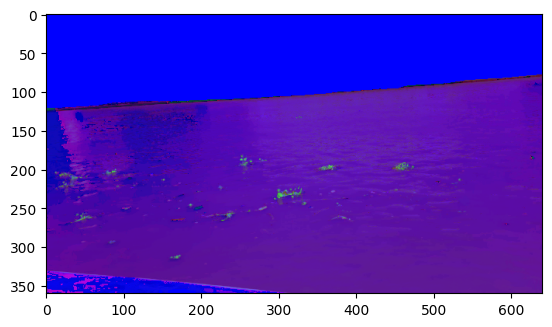

In [48]:
plt.imshow(new_img)

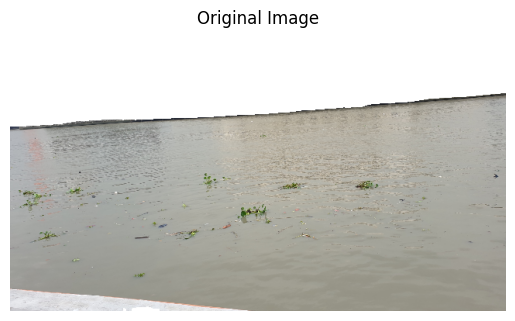

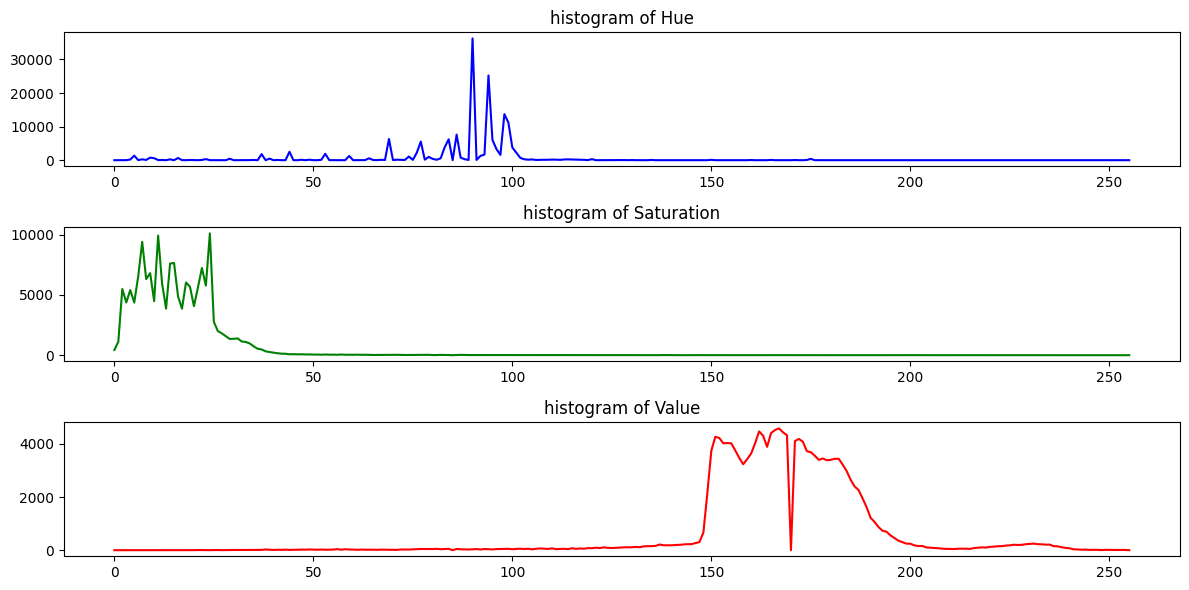

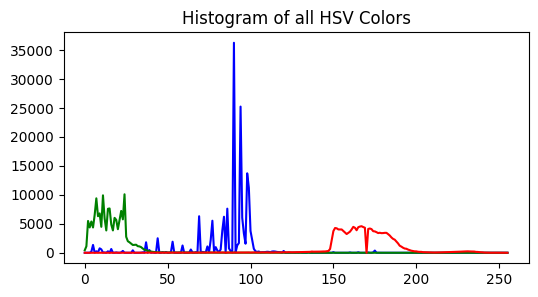

In [43]:
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow(removed_boat_image, 'hsv')
new_img = cv2.cvtColor(removed_boat_image, cv2.COLOR_BGR2HSV)

# Get RGB data from image
hue = cv2.calcHist([new_img], [0], None, [256], [1, 254])
saturation = cv2.calcHist([new_img], [1], None, [256], [1, 254])
value = cv2.calcHist([new_img], [2], None, [256], [1, 254])

_= plt.figure(figsize=(12, 6))

# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Hue")
plt.plot(hue, color="blue")

plt.subplot(3, 1, 2)
plt.title("histogram of Saturation")
plt.plot(saturation, color="green")

plt.subplot(3, 1, 3)
plt.title("histogram of Value")
plt.plot(value, color="red")

# for clear view
plt.tight_layout()

_= plt.figure(figsize=(6, 3))

# combined histogram
plt.title("Histogram of all HSV Colors")
plt.plot(hue, color="blue")
plt.plot(saturation, color="green")
plt.plot(value, color="red")
plt.show()

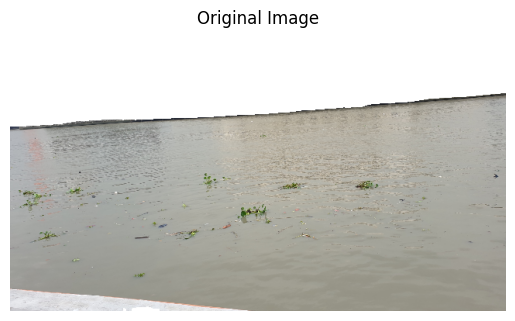

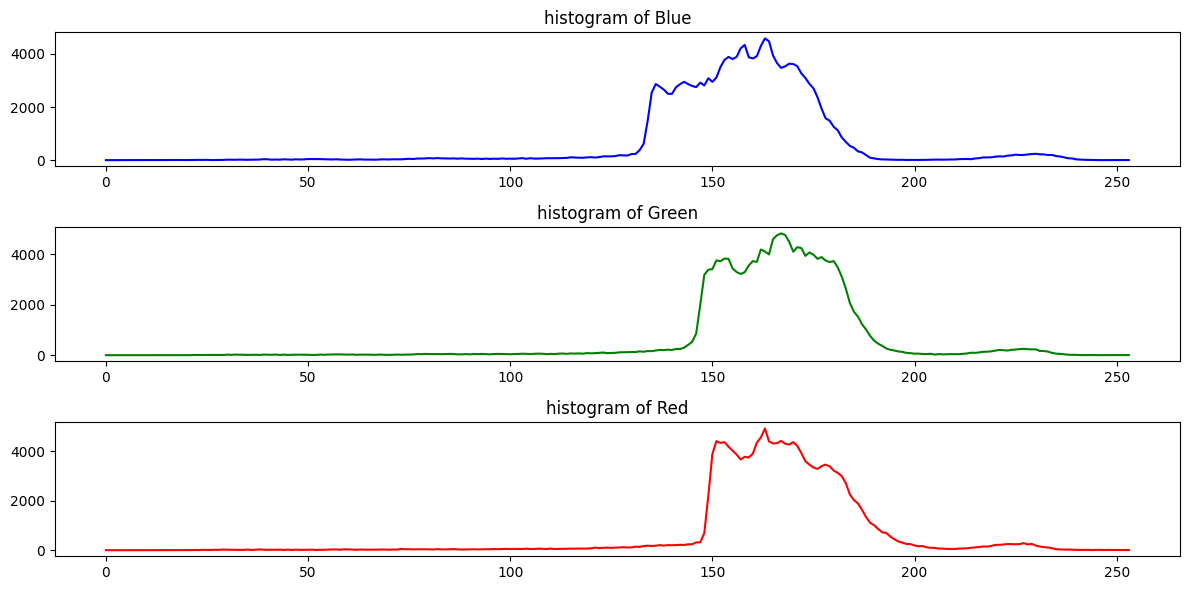

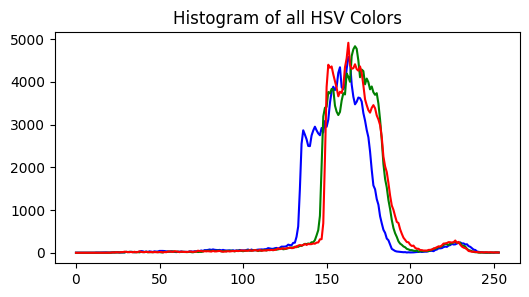

In [44]:
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow(removed_boat_image)

# Get RGB data from image
red_color = cv2.calcHist([removed_boat_image], [0], None, [254], [0, 254])
green_color = cv2.calcHist([removed_boat_image], [1], None, [254], [0, 254])
blue_color = cv2.calcHist([removed_boat_image], [2], None, [254], [0, 254])

_= plt.figure(figsize=(12, 6))

# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.plot(blue_color, color="blue")

plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.plot(green_color, color="green")

plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.plot(red_color, color="red")

# for clear view
plt.tight_layout()

_= plt.figure(figsize=(6, 3))

# combined histogram
plt.title("Histogram of all HSV Colors")
plt.plot(blue_color, color="blue")
plt.plot(green_color, color="green")
plt.plot(red_color, color="red")
plt.show()